In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [16]:
df = pd.read_csv('../data/row_data.csv')

In [3]:
# Sort data by date
df = df.sort_values(by='date')

# Drop 'date' column for now
df = df.drop(['date'], axis=1)

# Normalize data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

In [4]:
# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        X.append(seq[:-1])
        y.append(seq[-1][df.columns.get_loc("大盤_收盤價")])
    return np.array(X), np.array(y)

In [5]:
seq_length = 10  # for example, use the last 10 days to predict the next day
X, y = create_sequences(scaled_data, seq_length)

# Split data into training and testing (80-20 split for example)
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [7]:
# Model Creation
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(tf.keras.layers.LSTM(50))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mse')

In [8]:
# Model Training
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/50
49/49 [==============================] - 11s 24ms/step - loss: 0.0069 - val_loss: 0.0161
Epoch 2/50
49/49 [==============================] - 0s 9ms/step - loss: 4.6336e-04 - val_loss: 0.0080
Epoch 3/50
49/49 [==============================] - 0s 9ms/step - loss: 2.6742e-04 - val_loss: 0.0177
Epoch 4/50
49/49 [==============================] - 0s 9ms/step - loss: 2.3370e-04 - val_loss: 0.0157
Epoch 5/50
49/49 [==============================] - 0s 9ms/step - loss: 2.2438e-04 - val_loss: 0.0136
Epoch 6/50
49/49 [==============================] - 0s 10ms/step - loss: 2.1636e-04 - val_loss: 0.0114
Epoch 7/50
49/49 [==============================] - 0s 10ms/step - loss: 2.1815e-04 - val_loss: 0.0127
Epoch 8/50
49/49 [==============================] - 1s 11ms/step - loss: 2.1113e-04 - val_loss: 0.0080
Epoch 9/50
49/49 [==============================] - 0s 9ms/step - loss: 2.2752e-04 - val_loss: 0.0086
Epoch 10/50
49/49 [==============================] - 0s 9ms/step - loss: 2.0846e-

In [9]:
# Predictions
predictions = model.predict(X_test)

25/25 [==============================] - 1s 6ms/step


In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
# For Regression
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 0.0012095297783297446
Mean Absolute Error: 0.027004371073125148


In [12]:
# For Classification (predicting up or down movements)
y_test_direction = np.where(np.diff(y_test) >= 0, 1, 0)
predictions_direction = np.where(np.diff(predictions[:, 0]) >= 0, 1, 0)

accuracy = accuracy_score(y_test_direction, predictions_direction)
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 55.12%


Confusion Matrix:
[[183 179]
 [172 248]]


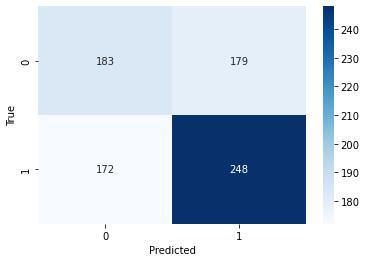

In [13]:
conf_matrix = confusion_matrix(y_test_direction, predictions_direction)
print("Confusion Matrix:")
print(conf_matrix)

# Plotting the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

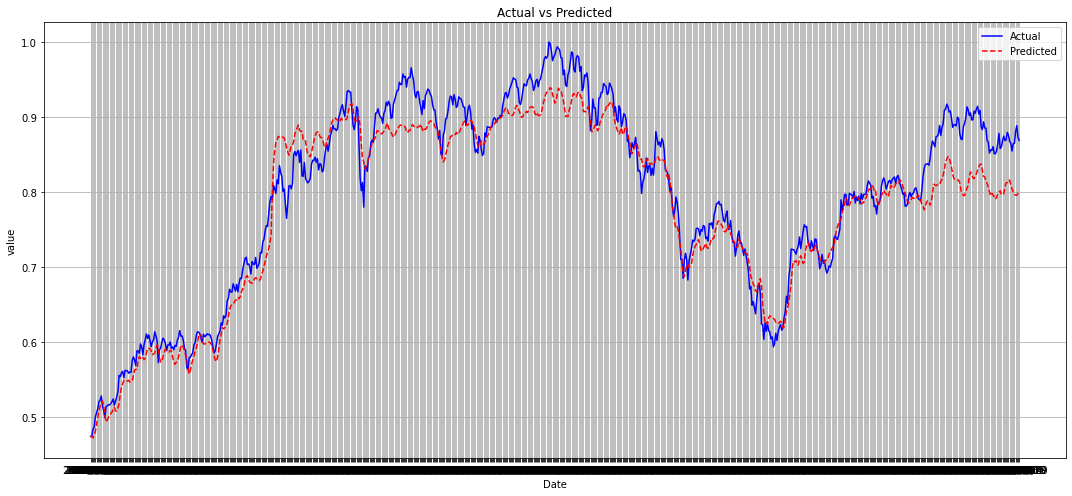

In [19]:
dates = df['date'].values[-len(y_test):]

# Plotting
plt.figure(figsize=(15, 7))
plt.plot(dates, y_test, label="Actual", color='blue')
plt.plot(dates, predictions, label="Predicted", color='red', linestyle='dashed')
plt.title('Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
model.save("LSTM_v1.h5")

In [ ]:
loaded_model = tf.keras.models.load_model('LSTM_v1.h5')